<img src="files/QHack_poster.png" >

<img src="files/MA_RGB_Blue.jpg" width="200">

In [1]:
import numpy as np
import qiskit
import qiskit_finance
from qiskit.algorithms import EstimationProblem, IterativeAmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation
from qiskit_aer.primitives import Sampler
import matplotlib.pyplot as plt
import time
# import covalent as ct

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

<font color=blue>
    
# The path to Quantum in production in the Financial Industry 
# The use case of Quantum Monte Carlo Simulation 

</font>

## Learning objectives of the challenge

**MAIN LEARNING OBJECTIVES**
1. Mapping a real problem to a quantum circuit. 
2. Programming quantum circuits. 
3. Optimizing quantum algorithms. 

**ABOUT THE INDUSTRY**

<div class="alert alert-block alert-success">
    
- What are the companies with potential use cases of quantum computing doing right now to prepare? 
    
- Why do financial institutions need to invest in Quantum Computing?
    
- What innovation framework do companies use to decide what emerging technology should be investigated?
    
</div>



**ABOUT THE PROBLEMS. SIZE. CLASSICAL METHODS. AND ~QUANTUM~ BUSINESS ADVANTAGE**
<div class="alert alert-block alert-success">

* What is the size of the problems real companies need to solve in production and when does quantum become relevant?

* What state of the art methods would quantum have to compete with?

* What benchmarks should we do to decide if we substitute a classical method with a quantum one?

* Should we talk about quantum advantage or business advantage?
    
</div>

**ABOUT INTEGRATION AND "QuantumOps"**

<div class="alert alert-block alert-success">

* What tools/ libraries need to be used in order to integrate quantum with other accelerators such as GPUs/ CPUs/ FPGAs etc?

* How do you orchestrate all the resources needed to solve a production size problem?

* How to manage the life cycle of a model in production?

* How do we integrate a quantum computer, with the current infrastructure a company has?

* How do we integrate a quantum solver with the current software products a company has?

* What are all the layers that we have to take into consideration when using a quantum computer in production? </div>

## The challenge

### Problem Statement 

Let $S_t$ be a stochastic process indexed by time $t$. Let the dynamics of $S_t$ be given by:

**Eq. (1)** $$ dS_t = \mu S_t dt + \sigma S_t dW_t $$ 

where $S_0=1$, $\mu= 0.1$ and $\sigma= 0.2$ are constants, and $dW_{t}$ is change in a standard Gaussian process in $dt$ time and can be thought of as:

$$dW_t=\mathcal{N}(0,1)\sqrt{dt}$$


This kind of stochastic process is known as a geometric Brownian motion (GBM) (also known as exponential Brownian motion).


### SECTION 1: The classical solution. Monte Carlo Simulation.

Using the above write a simulation code to compute:

* $\mathbb{E}[S_T]$

where T=10

Some theory:

* The expectation of a random variable can be estimated by averaging samples (let $X \stackrel{}{\sim} p(x)$):
$$\mathbb{E}[X]= \int xp(x)dx \approx \frac{1}{N}\sum_{j=1}^{N}X_j $$

* When performed on a digital computer (classical or quantum), any continuous $p(x)$ must be truncated and discretised:
$$\mathbb{E}[X]= \sum_x xp(x) \approx \frac{1}{N}\sum_{j=1}^{N}X_j $$


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Discretize the time between t=0 to t=T in 100 steps.
- Use **Eq. (1)** to generate 10000 paths between t=0 to t=T (discretize the differential equation.)
- Compute the expectation by averaging over the paths.
- Another option is to use the analytical solution of the SDE, which is possible for this Stochastical Differential equation.
    
</div>


This problem is usually solved using Monte Carlo simulation. Monte Carlo sampling is a set of techniques that randomly generate numerical quantities for the purpose of simulating a statistical distribution or computing a moment or other expectation thereof (e.g., mean, variance).

In [3]:
mu = 0.1
sigma = 0.2

In [40]:
# Write your code here
def s(s_current, steps, t, T):
    stepsize = T / steps
    dw = np.random.normal() * np.sqrt(stepsize)
    ds = mu * s_current * stepsize + sigma * s_current * dw
    if t < T:
        t += stepsize
        return s(s_current + ds, steps, t, T)
    else:
        return s_current + ds
    
def f(s):
    return s

def g(s):
    return np.max([s - 100, 0])

In [5]:
T = 10
steps = 1000
s0 = 50
s(s0, steps, 0, T)

139.8152243825497

In [65]:
n_samples = 10000
samples_f = [s(s0, steps, 0, T) for _ in range(n_samples)]
print(f"Classical expectation value S_T: {np.mean(samples_f)}")
samples_g = [g(s(s0, steps, 0, T)) for _ in range(n_samples)]
print(r"Classical expectation value max{S_T - 100, 0}: " + f"{np.mean(samples_g)}")

Classical expectation value S_T: 135.79837703946635
Classical expectation value max{S_T - 100, 0}: 49.75606546406951


In [66]:
n_qubits = 6
x_l, x_u = 0, 600
L = x_u - x_l

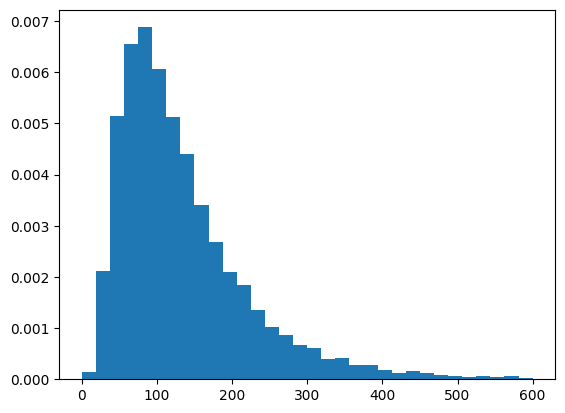

In [67]:
hist_data = plt.hist(samples_f, bins=2**(n_qubits - 1), density=True, range=(x_l, x_u))

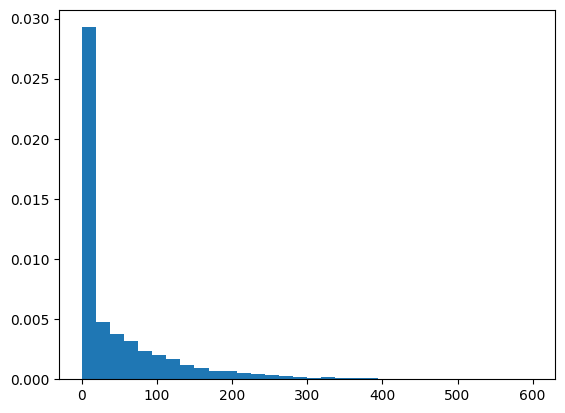

In [68]:
hist_data = plt.hist(samples_g, bins=2**(n_qubits - 1), density=True, range=(x_l, x_u))

### SECTION 2: The Quantum solution. Quantum Monte Carlo Integration + QAE
Now you are required to derive:
* $\mathbb{E}[max(S_T-100, 0)]$ 

with a quantum computer using the Quantum Amplitude Estimation Algorithm.

Some more theory:

* We may want to estimate the expectation when a function is applied to the samples:

$$\mathbb{E}[f(X)]= \sum_x f(x)p(x) \approx \frac{1}{N}\sum_{j=1}^{N}f(X_j) $$


* Monte-Carlo Integration is a three step process:

<div class="alert alert-block alert-info">
Prepare samples -> Apply a function -> average
</div>


* and Quantum Monte-Carlo Integration is essentially the same:

<div class="alert alert-block alert-info">
Prepare a state -> Apply circuit encoding the function -> QAE algorithm
</div>


#### BACKGROUND OF THE ALGORITHM

Quantum Amplitude Estimation (QAE) __[[1]](https://arxiv.org/abs/quant-ph/0005055)__  is a fundamental quantum algorithm with the potential to achieve a quadratic speedup for many applications that are classically solved through Monte Carlo (MC) simulation. 

This algorithm could provide an advantage in some relevant applications in the financial sector. In fact, it has been shown how to apply QAE to the problems of option pricing __[[2]](https://arxiv.org/abs/1905.02666)__, risk analysis __[[3]](https://www.nature.com/articles/s41534-019-0130-6)__, __[[4]](https://arxiv.org/abs/2212.07125)__, __[[5]](https://www.mdpi.com/1099-4300/25/4/593)__ and also for generical tasks such as numerical integration __[[6]](https://arxiv.org/abs/1504.06987)__, among others.

<div class="alert alert-block alert-info">
While the estimation error bound of classical MC simulation scales as O(1/√M), where M denotes the number of (classical) samples, QAE achieves a scaling of O(1/M) for M (quantum) samples, indicating the aforementioned quadratic speedup.

</div>


QAE was first proposed in 2000 by Brassard and others. However, the first version of the algorithm, that is, the canonical version, requires a very high number of qubits and circuit depth, which makes it impractical in today’s NISQ devices. QAE combines Quantum Phase Estimation (QPE) and Grover’s Algorithm.  Later studies have focused on how to optimize the QAE algorithm. The strategy has been to remove the QPE-dependency and use only Grover iterations. It has been empirically observed that including QPE in QAE does not have any advantages, it only increases the complexity. Moreover, the removal of the QPE-dependency has resulted in reducing the resource requirements of QAE, bringing closer the possibility of practical applications of QAE in the near-term.


There are 3 main pain points to work on when solving a problem with this algorithm:
1. Uploading the initial probability distribution.
2. Computation = iterations of the algorithm (circuit depth).
3. Measuring and Post processing.

Each  of the parts have their own challenge, and in order to maintain the theoretical quadratic speedup, we have to efficiently solve each of the steps.

There are different versions of QAE:

* Canonical QAE __[[1]](https://arxiv.org/abs/quant-ph/0005055)__
* Maximum Likelihood Amplitude Estimation MLAE __[[2]](https://arxiv.org/abs/1904.10246)__
* QAE Simplified QAES __[[3]](https://arxiv.org/abs/1908.10846)__
* Iterative QAE IQAE __[[4]](https://arxiv.org/abs/1912.05559)__
* Variational QAE __[[5]](https://arxiv.org/abs/2109.03687)__

and more.

In order to do Quantum Monte-Carlo Integration one may choose among the different versions of QAE.

In a recent paper, Steven Herbert proposes a method to do Quantum-monte Carlo Integration called Fourier QMCI __[[6]](https://arxiv.org/abs/2105.09100)__ that provides an optimal way to do the step of encoding the function into a circuit.

For more information on Quantum proposals to enhance Monte Carlo methods, read __[A Survey of Quantum Alternatives to Randomized Algorithms: Monte Carlo Integration and Beyond](https://arxiv.org/abs/2303.04945)__

You are required to work on the 3 steps mentioned above, and hand in the outputs defined below.

# Expected Outputs

## 1. Data uploading step. 
* Explore different techniques to efficiently upload the stochastic process. Choose and implement the technique you want and justify why. For simulation experiments, you may choose the number of samples in the probability distribution you want to consider, we recommend to start with 4. 

<font color=red>
Optional. Advanced exercise. (We recommend to try this after solving the rest of the challenge). Try to encode a Cox-Ingersoll-Ross process into a quantum computer. What about a Heston model?</font> 


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Read __[The Problem with Grover-Rudolph State Preparation for Quantum Monte-Carlo](https://arxiv.org/abs/2101.02240)__ to understand why efficiently doing this step is important.
    
- __[qGAN](https://www.nature.com/articles/s41534-019-0223-2)__ have been proposed as an alternative promising way of efficiently uploading data.
    
- Read about stochastic processes uploading in __[Quantum-enhanced analysis of discrete stochastic processes](https://www.nature.com/articles/s41534-021-00459-2)__
    
</div>

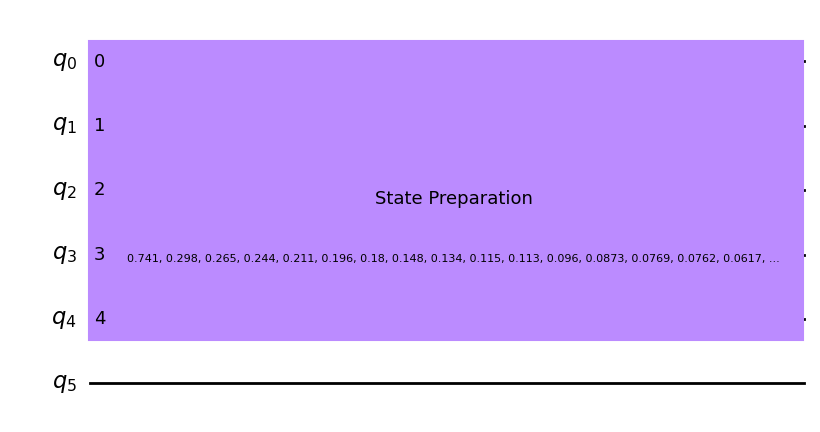

In [70]:
from qiskit import QuantumCircuit

qc_P = QuantumCircuit(n_qubits)
initial_probs = hist_data[0] * L / 2**(n_qubits - 1)
initial_probs = np.sqrt(initial_probs)
qc_P.prepare_state(initial_probs, qc_P.qubits[:-1])
qc_P.draw(output="mpl")


## 2. QAE. 
* You are asked to implement Fourier QMCI __[[6]](https://arxiv.org/abs/2105.09100)__ and apply it to the function described in the problem statement $max(S_T-100, 0)$
* What benefits does it have vs the other versions? 


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- You do not need to derive the circuits of each version of QAE from scratch. Qiskit has some of the versions of QAE implemented as classes. You can explore the circuits using these classes. Check them out __[here](https://qiskit.org/documentation/apidoc/algorithms.html)__.
- Qiskit can also help deriving the __[circuit depth](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.depth.html)__.
- Note that Fourier QMCI can make use of any of the versions of QAE.
    
</div>

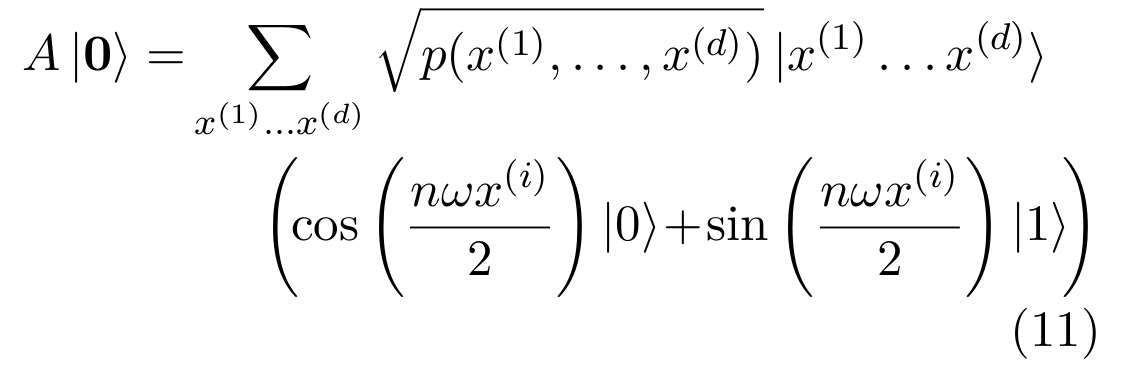

In [76]:
from IPython.display import Image
display(Image(filename='/home/sam/Documents/qechackethz23/formula.png'))

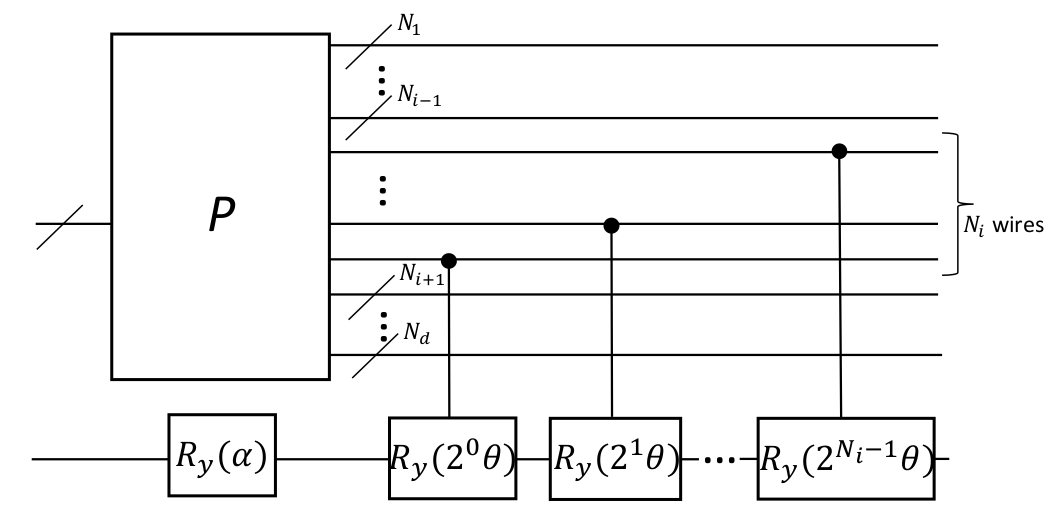

In [77]:
display(Image(filename='/home/sam/Documents/qechackethz23/circuit.png'))

In [11]:
def add_rotations(qc, n, L, x_l, n_qubits, beta):
    omega = 2 * np.pi / L
    alpha = n * omega * x_l - beta
    delta = L / 2 ** n_qubits
    theta = n * omega * delta
    
    qc.ry(alpha, -1)
    for i in range(n_qubits - 1): # perhaps this loop should be reversed
        qc.cry(2 ** i * theta, n_qubits - 2 - i, -1)

In [12]:
def construct_qc_A(qc_P, n, L, x_l, n_qubits, beta):
    qc_P_copy = qc_P.copy()
    add_rotations(qc_P_copy, n, L, x_l, n_qubits, beta)
    return qc_P_copy

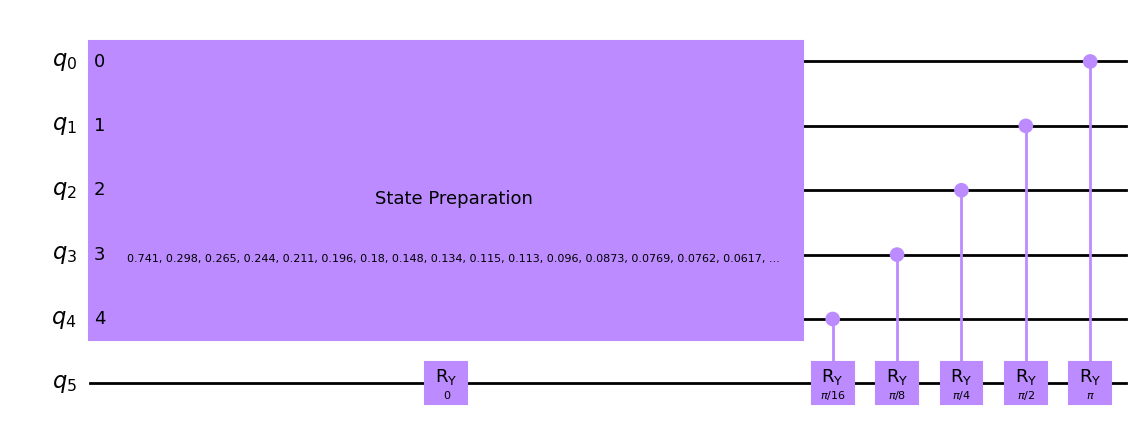

In [78]:
qc_A = construct_qc_A(qc_P, 2, L, x_l, n_qubits, 0)
qc_A.draw(output="mpl")

In [37]:
# Depth of the circuit
qc_A.decompose().decompose().decompose().decompose().decompose().decompose().depth()

76

In [20]:
from scipy.integrate import quad

# Define Fourier coefficients
def a_n(f, n, L):
    return 2 / L * quad(lambda s: f(s) * np.cos(2 * np.pi * n * s / L), 0, L)[0]
def b_n(f, n, L):
    return 2 / L * quad(lambda s: f(s) * np.sin(2 * np.pi * n * s / L), 0, L)[0]

### Expectation value of $S_T$

(0.0, 600.0)

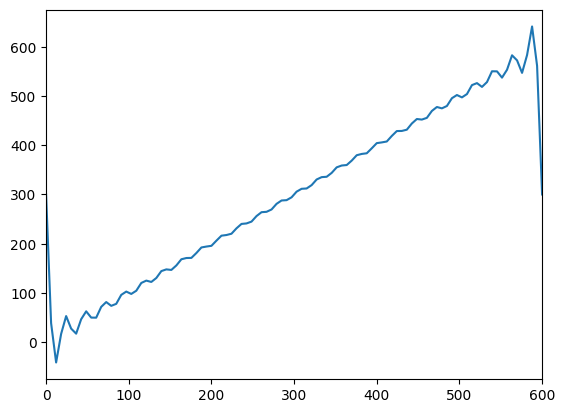

In [45]:
def fourier_series(t, n_max):
    L = 600
    res = a_n(f, 0, L) / 2
    if n_max == 0:
        return res
    else:
        n = 1
        while n <= n_max:
            res += a_n(f, n, L) * np.cos(2 * np.pi * n * t / L) + \
                   b_n(f, n, L) * np.sin(2 * np.pi * n * t / L)
            n += 1
        return res
    
t = np.linspace(x_l, x_u, 100)
plt.plot(t, fourier_series(t, 25))
plt.xlim(x_l, x_u)

In [46]:
def compute_exp_val(n_max, qc_P, x_l, n_qubits, ae=True):
    epsilon = 0.05
    alpha = 0.05
    mu_n = np.empty((2, n_max))
    
    first_term = a_n(f, 0, L) / 2
    for i, beta in enumerate([0., np.pi / 2]):
        for n in range(1, n_max + 1):
            time_start = time.time()
            
            if ae:
                problem = EstimationProblem(
                    state_preparation=construct_qc_A(qc_P, n, L, x_l, n_qubits, beta),
                    objective_qubits=[-1]
                )
                ae = IterativeAmplitudeEstimation(
                    epsilon_target=epsilon, 
                    alpha=alpha, 
                    sampler=Sampler(run_options={"shots": 100})
                )
                qae_res = ae.estimate(problem).estimation_processed
            else:
                qc_A = construct_qc_A(qc_P, n, L, x_l, n_qubits, beta)
#                 from qiskit import ClassicalRegister
#                 creg = ClassicalRegister(1)
#                 qc_A.add_register(creg)
#                 qc_A.measure(-1, 0)
                from qiskit import BasicAer
                backend = BasicAer.get_backend('statevector_simulator')
                from qiskit.execute_function import execute
                job = execute(qc_A, backend)
                result = job.result()
                state_vector = result.get_statevector()
                qae_res = np.sum(np.abs(state_vector[1::2]) ** 2)
#                 print(qae_res)
#                 print(state_vector)
#                 print(state_vector[1::2])
            qae_res = 1 - 2 * qae_res
                
            if beta == 0.:
                mu_n[i, n - 1] = qae_res * a_n(f, n, L)
            elif beta == np.pi / 2:
                mu_n[i, n - 1] = qae_res * b_n(f, n, L)
            else:
                raise ValueError("Invalid value for beta")
            time_end = time.time()
            time_diff = time_end - time_start
            print(f"Calculated (beta, n) = ({beta:.2f}, {n})  ({time_diff:.1f}s)")
    return first_term + np.sum(mu_n)

In [47]:
exp_val_f = compute_exp_val(10, qc_P, x_l, n_qubits, ae=True)
exp_val_f

Calculated (beta, n) = (0.00, 1)  (0.8s)
Calculated (beta, n) = (0.00, 2)  (0.9s)
Calculated (beta, n) = (0.00, 3)  (0.6s)
Calculated (beta, n) = (0.00, 4)  (1.0s)
Calculated (beta, n) = (0.00, 5)  (0.8s)
Calculated (beta, n) = (0.00, 6)  (0.8s)
Calculated (beta, n) = (0.00, 7)  (0.9s)
Calculated (beta, n) = (0.00, 8)  (0.8s)
Calculated (beta, n) = (0.00, 9)  (0.6s)
Calculated (beta, n) = (0.00, 10)  (0.6s)
Calculated (beta, n) = (1.57, 1)  (1.2s)
Calculated (beta, n) = (1.57, 2)  (0.6s)
Calculated (beta, n) = (1.57, 3)  (0.6s)
Calculated (beta, n) = (1.57, 4)  (0.8s)
Calculated (beta, n) = (1.57, 5)  (0.9s)
Calculated (beta, n) = (1.57, 6)  (0.6s)
Calculated (beta, n) = (1.57, 7)  (0.8s)
Calculated (beta, n) = (1.57, 8)  (0.9s)
Calculated (beta, n) = (1.57, 9)  (1.0s)
Calculated (beta, n) = (1.57, 10)  (0.6s)


141.92045265594425

### Expectation value of $max\{S_T - 100, 0\}$

(0.0, 600.0)

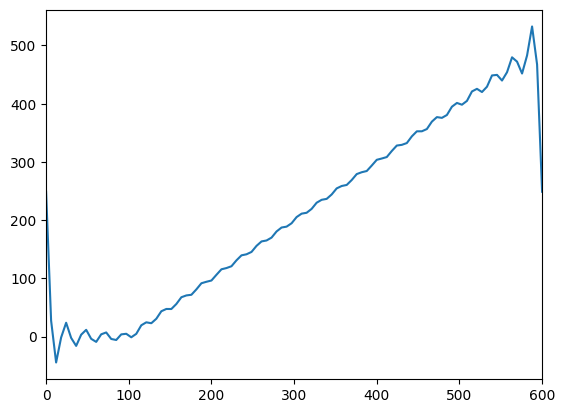

In [48]:
def fourier_series(t, n_max):
    L = 600
    res = a_n(g, 0, L) / 2
    if n_max == 0:
        return res
    else:
        n = 1
        while n <= n_max:
            res += a_n(g, n, L) * np.cos(2 * np.pi * n * t / L) + \
                   b_n(g, n, L) * np.sin(2 * np.pi * n * t / L)
            n += 1
        return res
    
# x_l, x_u = -100, 700
t = np.linspace(x_l, x_u, 100)
plt.plot(t, fourier_series(t, 25))
plt.xlim(x_l, x_u)

In [57]:
def compute_exp_val(n_max, qc_P, x_l, n_qubits, ae=True):
    epsilon = 0.05
    alpha = 0.05
    mu_n = np.empty((2, n_max))
    
    first_term = a_n(g, 0, L) / 2
    for i, beta in enumerate([0., np.pi / 2]):
        for n in range(1, n_max + 1):
            time_start = time.time()
            
            if ae:
                problem = EstimationProblem(
                    state_preparation=construct_qc_A(qc_P, n, L, x_l, n_qubits, beta),
                    objective_qubits=[-1]
                )
                ae = IterativeAmplitudeEstimation(
                    epsilon_target=epsilon, 
                    alpha=alpha, 
                    sampler=Sampler(run_options={"shots": 100})
                )
                qae_res = ae.estimate(problem).estimation_processed
            else:
                qc_A = construct_qc_A(qc_P, n, L, x_l, n_qubits, beta)
#                 from qiskit import ClassicalRegister
#                 creg = ClassicalRegister(1)
#                 qc_A.add_register(creg)
#                 qc_A.measure(-1, 0)
                from qiskit import BasicAer
                backend = BasicAer.get_backend('statevector_simulator')
                from qiskit.execute_function import execute
                job = execute(qc_A, backend)
                result = job.result()
                state_vector = result.get_statevector()
                qae_res = np.sum(np.abs(state_vector[1::2]) ** 2)
#                 print(qae_res)
#                 print(state_vector)
#                 print(state_vector[1::2])
            qae_res = 1 - 2 * qae_res
                
            if beta == 0.:
                mu_n[i, n - 1] = qae_res * a_n(g, n, L)
            elif beta == np.pi / 2:
                mu_n[i, n - 1] = qae_res * b_n(g, n, L)
            else:
                raise ValueError("Invalid value for beta")
            time_end = time.time()
            time_diff = time_end - time_start
            print(f"Calculated (beta, n) = ({beta:.2f}, {n})  ({time_diff:.1f}s)")
    return first_term + np.sum(mu_n)

In [51]:
exp_val_g = compute_exp_val(10, qc_P, x_l, n_qubits, ae=True)
exp_val_g

Calculated (beta, n) = (0.00, 1)  (0.7s)
Calculated (beta, n) = (0.00, 2)  (0.8s)
Calculated (beta, n) = (0.00, 3)  (0.9s)
Calculated (beta, n) = (0.00, 4)  (0.8s)
Calculated (beta, n) = (0.00, 5)  (0.8s)
Calculated (beta, n) = (0.00, 6)  (0.9s)
Calculated (beta, n) = (0.00, 7)  (0.8s)
Calculated (beta, n) = (0.00, 8)  (0.7s)
Calculated (beta, n) = (0.00, 9)  (0.6s)
Calculated (beta, n) = (0.00, 10)  (1.0s)
Calculated (beta, n) = (1.57, 1)  (0.6s)
Calculated (beta, n) = (1.57, 2)  (1.1s)
Calculated (beta, n) = (1.57, 3)  (1.5s)
Calculated (beta, n) = (1.57, 4)  (1.0s)
Calculated (beta, n) = (1.57, 5)  (1.2s)
Calculated (beta, n) = (1.57, 6)  (1.1s)
Calculated (beta, n) = (1.57, 7)  (0.6s)
Calculated (beta, n) = (1.57, 8)  (0.6s)
Calculated (beta, n) = (1.57, 9)  (1.0s)
Calculated (beta, n) = (1.57, 10)  (0.9s)


48.074095009477645

## 3. Execution
* Let's think about parallelization: What versions of QAE can be parallelized? At which level (iteration/shot)? When does it become relevant? What advantage does it bring compared to a sequential execution?
* Explain how you would parallelize the Fourier QMCI and the QAE you have chosen if that QAE version can be paralellized.
* Define a workload of tasks and orquestrate its execution. Include any assumptions you make (e.g. I have access to 20 Quantum Computers based in the same data center...).
* Compare the different approaches.


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Read the steps of the algorithm and think whether iterations depend on the previous one or the can be done simultaneously in different quantum backends. 
_ Think about how to parallelize Fourier QMCI.
- Think about the number of iterations, circuit depth, and the number of shots.
- Use __[covalent.xyz](https://www.covalent.xyz)__ to define a workflow of the things you need to execute.
- Check the opensource platform __[NVIDIA CUDA Quantum](https://developer.nvidia.com/cuda-quantum)__ and their view on orchestration of hybrid workflows. 
- __[Orquestra](https://www.orquestra.io)__ by Zapata Computing is not open source, but may also give you some ideas.
    
- <font color=red> (Optional. Avanced) Other proposals __[Error Resilient Quantum Amplitude Estimation from Parallel Quantum Phase Estimation](https://arxiv.org/abs/2204.01337)__ </font>
    
</div>

In [88]:
# Write your code here

<font color=red>

## 4. Noise analysis step (Optional. Advanced.)

(We recommend to try this after solving the rest of the challenge).
    
* Can you execute QMC in NISQ devices?
* How would you execute it in a quantum backend?
* How did you compile the circuits? What is the circuit depth after transpilation?
* Did you use any noise mitigation technique? If yes, explain which one and how if affected the results.
    
</font>




<div class="alert alert-block alert-warning">
<b>Hints:</b> 

- You can use an open backend from IBM Quantum, or an Aer simulator.
    
- Check this paper about __[Noise-Aware QAE](https://arxiv.org/abs/2109.04840)__

- You can use __[Fire Opal](https://q-ctrl.com/fire-opal)__ to optimize your results. __[Documentation](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-set-up-your-environment-and-install-fire-opal)__


    
</div>




In [ ]:
# Write your code here

## 5. Benchmarking
* Do you estimate this use case will benefit from NISQ devices or do we need Fault Tolerant Quantum computers?
* What metric would be more appropiate to compare the performance of your Quantum Monte Carlo solver vs the current classical methods?
* <font color=red> (Optional. Advanced) Assume you are a quant at a financial firm. You need to apply Monte Carlo simulation to price (i.e. the expectation of the total assets value) of a portfolio of fixed-income assets (e.g. 10k assets). An accuracy of the order of epsilon = 10e-6 is needed. Notice that the underlying uncertainty of fixed-income assets stems from interest rate and they do not have to follow a GBM like model. For simplicity, take into account that interest rates are only modeled up to one period (T=1), resulting on one-dimensional distribution. There are other models typically used to model the paths of interest rates. Make a rough but reasonable estimation of the quantum hardware resources needed to implement quantum Monte Carlo simulation for this set up. </font>


Cite your references.

In [ ]:
# Write your code here

## 6. Pitch your quantum strategy to a client: a bank
Imagine you are part of the Quantum team at Moody's. You are meeting the CIO of an important bank in the US, and you need to convince him/her in 5 minutes about why they should start investing in quantum computing today, and define the steps of a high level roadmap they would need to follow to get quantum ready. You can use the Quantum Monte Carlo use case as a proof of concept to support your pitch. 

You may use up to 3 slides, including roadmap, PoC results and executive summary on why to invest in quantum today.


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Research what is an executive summary, and an elevator pitch, and try to follow some of the ideas of these communication tools.
- Think about the person you are presenting to. Are they technical people? What is important to them? Build a empathy map to help you build the right message.

</div>

<img src="files/empathymap.png"  width="200">

In [5]:
# Build your presentation and rehearse your pitch!

# This is the end of the challenge. Good luck...

<img src="files/keepcalm.png"  width="200">